In [2988]:
from simdinov2.data import DataAugmentationDINO
from torchvision import datasets
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
import math
import random
from functools import partial

In [ ]:
data_transform = DataAugmentationDINO(
    # [0.4, 0.6], # global_crops scale
    [1, 1], # global_crops scale
    # [0.25, 0.4], # local_crops scale
    [1, 1], # local_crops scale
    # [0.01, 0.05], # local_crops ratio
    10, # number of local_crops
    global_crops_size=224,
    local_crops_size=98,
)

In [2990]:
dir = "training/" 
dataset = datasets.ImageFolder(dir, transform=data_transform, target_transform=lambda _: ())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=None)

In [2972]:
for i, (img, _) in enumerate(dataloader):
    print(img.keys())
    print(img["global_crops"][0].shape) # first global crops
    print(img["global_crops"][1].shape) # second global crops
    print(len(img["global_crops"]))
    print(len(img["local_crops"]))

dict_keys(['global_crops', 'global_crops_teacher', 'local_crops', 'offsets'])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
2
2
dict_keys(['global_crops', 'global_crops_teacher', 'local_crops', 'offsets'])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
2
2


In [2973]:
img, _ = dataset[0]

In [2974]:
img.keys()

dict_keys(['global_crops', 'global_crops_teacher', 'local_crops', 'offsets'])

In [2975]:
# Extract the teacher's global crops
global_crops_teacher = img["global_crops_teacher"] # 2 images
global_crops_teacher = img['global_crops']
local_crops= img["local_crops"] # 10 images

In [2976]:
dataset = datasets.ImageFolder(dir, transform=None)
img_test, _ = dataset[1]

In [2977]:
class MaskingGenerator:
    def __init__(
        self,
        input_size,
        num_masking_patches=None,
        min_num_patches=4,
        max_num_patches=None,
        min_aspect=0.3,
        max_aspect=None,
    ):
        if not isinstance(input_size, tuple):
            input_size = (input_size,) * 2
        self.height, self.width = input_size

        self.num_patches = self.height * self.width
        self.num_masking_patches = num_masking_patches

        self.min_num_patches = min_num_patches
        self.max_num_patches = num_masking_patches if max_num_patches is None else max_num_patches

        max_aspect = max_aspect or 1 / min_aspect
        self.log_aspect_ratio = (math.log(min_aspect), math.log(max_aspect))

    def __repr__(self):
        repr_str = "Generator(%d, %d -> [%d ~ %d], max = %d, %.3f ~ %.3f)" % (
            self.height,
            self.width,
            self.min_num_patches,
            self.max_num_patches,
            self.num_masking_patches,
            self.log_aspect_ratio[0],
            self.log_aspect_ratio[1],
        )
        return repr_str

    def get_shape(self):
        return self.height, self.width

    def _mask(self, mask, max_mask_patches):
        delta = 0
        for _ in range(10):
            target_area = random.uniform(self.min_num_patches, max_mask_patches)
            aspect_ratio = math.exp(random.uniform(*self.log_aspect_ratio))
            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))
            if w < self.width and h < self.height:
                top = random.randint(0, self.height - h)
                left = random.randint(0, self.width - w)

                num_masked = mask[top : top + h, left : left + w].sum()
                # Overlap
                if 0 < h * w - num_masked <= max_mask_patches:
                    for i in range(top, top + h):
                        for j in range(left, left + w):
                            if mask[i, j] == 0:
                                mask[i, j] = 1
                                delta += 1

                if delta > 0:
                    break
        return delta
    

    # def _mask(self, mask, max_mask_patches):
    #     delta = 0
    #     for _ in range(10):  # Try 10 times to find a valid patch
    #         target_area = random.uniform(self.min_num_patches, max_mask_patches)
    #         aspect_ratio = math.exp(random.uniform(*self.log_aspect_ratio))
    #         h = int(round(math.sqrt(target_area * aspect_ratio)))
    #         w = int(round(math.sqrt(target_area / aspect_ratio)))

    #         if w < self.width and h < self.height:
    #             # Force the mask to be around the center
    #             center_h = self.height // 2
    #             center_w = self.width // 2

    #             # Limit movement to be near the center
    #             top = max(0, min(center_h - h // 2, self.height - h))
    #             left = max(0, min(center_w - w // 2, self.width - w))

    #             num_masked = mask[top : top + h, left : left + w].sum()

    #             if 0 < h * w - num_masked <= max_mask_patches:
    #                 for i in range(top, top + h):
    #                     for j in range(left, left + w):
    #                         if mask[i, j] == 0:
    #                             mask[i, j] = 1
    #                             delta += 1

    #             if delta > 0:
    #                 break
    #     return delta

    def __call__(self, num_masking_patches=0):
        mask = np.zeros(shape=self.get_shape(), dtype=bool)
        mask_count = 0
        while mask_count < num_masking_patches:
            max_mask_patches = num_masking_patches - mask_count
            max_mask_patches = min(max_mask_patches, self.max_num_patches)

            delta = self._mask(mask, max_mask_patches)
            if delta == 0:
                break
            else:
                mask_count += delta

        return mask

In [2978]:
img_size = 224
patch_size = 14

mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),
    max_num_patches=0.1 * img_size // patch_size * img_size // patch_size,
)

# mask_generator = MaskingGenerator(
#     input_size=(img_size // patch_size, img_size // patch_size), # 16 by 16
#     max_num_patches=3,
# )

In [2979]:
max_num_patches=0.1 * img_size // patch_size * img_size // patch_size

In [2980]:
max_num_patches

16.0

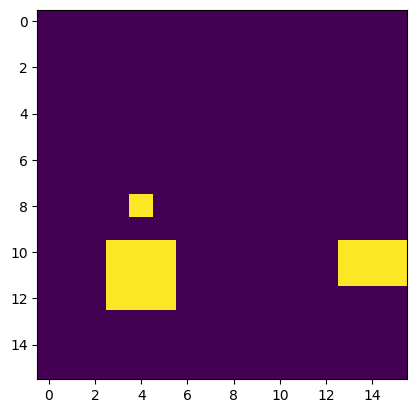

In [2981]:
# mask = mask_generator(0)
mask = mask_generator(num_masking_patches=0.1 * img_size // patch_size * img_size // patch_size)
plt.imshow(mask)

In [2982]:
mask.shape

(16, 16)

In [2983]:
def is_patch_black(patch, threshold=0.6):
    """
    Check if a patch is entirely black in the normalized ImageNet range.
    
    A patch is considered black if all pixels are very close to the expected normalized black value.
    """
    # imagenet_black = torch.tensor([-2.12, -2.04, -1.80], device=patch.device).view(3, 1, 1)  # (C, 1, 1)
    # return torch.all(torch.abs(patch - imagenet_black) < threshold)

    threshold = 0.6

    # ImageNet normalization constants
    imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=patch.device).view(3, 1, 1)  # (C, 1, 1)
    imagenet_std = torch.tensor([0.229, 0.224, 0.225], device=patch.device).view(3, 1, 1)  # (C, 1, 1)
    
    # Denormalize the patch
    denormalized_patch = patch * imagenet_std + imagenet_mean
    
    # Check if all values are very close to the black value (0, 0, 0)
    black_value = torch.tensor([0.0, 0.0, 0.0], device=patch.device).view(3, 1, 1)
    return torch.all(torch.abs(denormalized_patch - black_value) <= threshold) # understanding threshold

def mask_local_crops(crops, mask_ratio_tuple, mask_probability,n_tokens,patch_size=14):
     
    B = len(crops)
    N = n_tokens
    n_samples_masked = int(B * mask_probability)
    probs = torch.linspace(*mask_ratio_tuple, n_samples_masked + 1)
    upperbound = 0
    masks_list = []

    _, _, H, W = crops.shape  # Batch size, Channels, Height, Width
    H_patches = H // patch_size  # Number of patches along height
    W_patches = W // patch_size  # Number of patches along width
    Total_patches = H_patches * W_patches  # Total patches per image


    for i in range(B):
            non_black_patches = []
            patch_idx = 0
            pixel_indices = [] 

            # Extract patches and check if they are black
            for row in range(H_patches):
                for col in range(W_patches):
                    r_start = row * patch_size
                    c_start = col * patch_size

                    # Extract patch (C, patch_size, patch_size)
                    patch = crops[i, :, r_start:r_start + patch_size, c_start:c_start + patch_size]
                    
                    if not is_patch_black(patch):  # If patch is not black, add to list
                        non_black_patches.append(patch_idx)

                    patch_idx += 1  # Track patch index
                        # Mask only non-black patches
                        
            if non_black_patches:
                non_black_patches = non_black_patches[2:-1]
                # num_mask_patches = int(len(non_black_patches) * random.uniform(*mask_ratio_tuple))
                num_mask_patches = 3
                masked_indices = random.sample(non_black_patches, num_mask_patches)

                mask = torch.zeros(Total_patches, dtype=torch.bool)  # Default all patches to be unmasked (0)
                mask[masked_indices] = 1  # Set chosen patches to be masked (1)
            else:
                mask = torch.zeros(Total_patches, dtype=torch.bool)  # No masking if all patches are black
            
            mask = mask.view(H_patches, W_patches)  # Reshape to original image divided by patch size
            masks_list.append(mask)  # Append mask to list
    random.shuffle(masks_list)
    masks_list = random.choices(masks_list, k=n_samples_masked)

    mask_generator_local = MaskingGenerator(
    input_size=(H // patch_size, W // patch_size),
    max_num_patches=0.1 * img_size // patch_size * img_size // patch_size,
    )
    for i in range(0, n_samples_masked):
        masks_list.append(torch.BoolTensor(mask_generator_local(num_masking_patches=0))) # no mask
    random.shuffle(masks_list)

    collated_masks = torch.stack(masks_list).flatten(1) 

    mask_indices_list = collated_masks.flatten().nonzero().flatten() # get all masked indices
    masks_weight = (1 / collated_masks.sum(-1).clamp(min=1.0)).unsqueeze(-1).expand_as(collated_masks)[collated_masks]

    return collated_masks, mask_indices_list, masks_weight

     

def collate_data_and_cast(samples_list, mask_ratio_tuple, mask_probability, dtype, n_tokens=None, mask_generator=None, drop_masks=False, patch_size=14):
    # dtype = torch.half  # TODO: Remove

    n_global_crops = len(samples_list["global_crops"])
    n_local_crops = len(samples_list["local_crops"])


    collated_global_crops_list = []  # Initialize an empty list
    collated_local_crops_list = []
    
    # Iterate over each sample in samples_list
    for i in range(len(samples_list["global_crops"])):  # Iterate over global crops indices
        collated_global_crops_list.append(samples_list["global_crops"][i])  # Append each crop

    collated_global_crops = torch.stack(collated_global_crops_list)  # Convert to tensor
    # collated_global_crops = torch.stack([samples_list["global_crops"][i] for i in range(samples_list["global_crops"])])


    # Iterate over each sample in samples_list
    for i in range(len(samples_list["local_crops"])):  # Iterate over global crops indices
        collated_local_crops_list.append(samples_list["local_crops"][i])  # Append each crop
    collated_local_crops = torch.stack(collated_local_crops_list)  # Convert to tensor
    # collated_local_crops = torch.stack([samples_list["local_crops"][i] for i in range(samples_list["local_crops"])])

    B = len(collated_global_crops)
    N = n_tokens
    n_samples_masked = int(B * mask_probability)
    probs = torch.linspace(*mask_ratio_tuple, n_samples_masked + 1)
    upperbound = 0
    masks_list = []

    _, _, H, W = collated_global_crops.shape  # Batch size, Channels, Height, Width
    H_patches = H // patch_size  # Number of patches along height
    W_patches = W // patch_size  # Number of patches along width
    Total_patches = H_patches * W_patches  # Total patches per image

    if drop_masks:
        len_keep = int(N * (1 - mask_probability))
        
        noise = torch.rand(B, N)  # noise in [0, 1]
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        # keep the first subset
        #ids_keep = ids_shuffle[:, :len_keep]
        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([B, N], dtype=torch.bool)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        collated_masks = torch.gather(mask, dim=1, index=ids_restore)
        upperbound = N*B*mask_probability
    else:
        for i in range(B):
                    non_black_patches = []
                    patch_idx = 0
                    pixel_indices = [] 

                    # Extract patches and check if they are black
                    for row in range(H_patches):
                        for col in range(W_patches):
                            r_start = row * patch_size
                            c_start = col * patch_size

                            # Extract patch (C, patch_size, patch_size)
                            patch = collated_global_crops[i, :, r_start:r_start + patch_size, c_start:c_start + patch_size]
                            
                            if not is_patch_black(patch):  # If patch is not black, add to list
                                non_black_patches.append(patch_idx)

                            patch_idx += 1  # Track patch index
                               # Mask only non-black patches
                               
                    if non_black_patches:
                        non_black_patches = non_black_patches[5:-5]
                        # num_mask_patches = int(len(non_black_patches) * random.uniform(*mask_ratio_tuple))
                        num_mask_patches = 3
                        masked_indices = random.sample(non_black_patches, num_mask_patches)

                        mask = torch.zeros(Total_patches, dtype=torch.bool)  # Default all patches to be unmasked (0)
                        mask[masked_indices] = 1  # Set chosen patches to be masked (1)
                    else:
                        mask = torch.zeros(Total_patches, dtype=torch.bool)  # No masking if all patches are black
                    
                    mask = mask.view(H_patches, W_patches)  # Reshape to original image divided by patch size
                    masks_list.append(mask)  # Append mask to list

        masks_list = random.choices(masks_list, k=n_samples_masked)

        # for i in range(0, n_samples_masked):
        #     prob_min = probs[i]
        #     prob_max = probs[i + 1]
        #     masks_list.append(torch.BoolTensor(mask_generator(num_masking_patches=int(N * random.uniform(prob_min, prob_max))))) # mask patches (img_size/patch, image_size/patch)
        #     upperbound += int(N * prob_max)
        for i in range(0, n_samples_masked):
            masks_list.append(torch.BoolTensor(mask_generator(num_masking_patches=0))) # no mask
        random.shuffle(masks_list)
        # collated_masks = torch.stack(masks_list).flatten(1) #(N, img_size//patch_size * img_size//patch_size)
        collated_masks = torch.stack(masks_list).flatten(1) #(N, img_size//patch_size * img_size//patch_size)
    mask_indices_list = collated_masks.flatten().nonzero().flatten() # get all masked indices

    masks_weight = (1 / collated_masks.sum(-1).clamp(min=1.0)).unsqueeze(-1).expand_as(collated_masks)[collated_masks]

    collated_local_mask, local_mask_indices_list, local_masks_weight = mask_local_crops(collated_local_crops, mask_ratio_tuple, mask_probability, n_tokens, patch_size=14)
 
    return {
        "collated_global_crops": collated_global_crops.to(dtype), # global crops image tensor
        "collated_local_crops": collated_local_crops.to(dtype), # local crops image tensor
        "collated_masks": collated_masks, # mask NxN (e.g., 16x16)
        "mask_indices_list": mask_indices_list, # list of mask patch indices
        "masks_weight": masks_weight,
        "upperbound": upperbound,
        "n_masked_patches": torch.full((1,), fill_value=mask_indices_list.shape[0], dtype=torch.long), # number of masked patches
        "collated_local_masks": collated_local_mask, # local mask NxN (e.g., 16x16)
        "local_mask_indices_list": local_mask_indices_list, # list of local mask patch indices
        "local_masks_weight": local_masks_weight,
        "n_local_masked_patches": torch.full((1,), fill_value=local_mask_indices_list.shape[0], dtype=torch.long),
    }

In [2984]:
img_size = 224
patch_size = 14
n_tokens = (img_size // patch_size) ** 2 # 121 tokens
inputs_dtype = torch.half

data_loader = collate_data_and_cast(
    img,
    mask_ratio_tuple=(0.1, 0.2),
    mask_probability=0.5,
    dtype=torch.half,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    drop_masks=False,
)

In [2985]:
collated_masks = data_loader["collated_masks"]
mask_indices_list = data_loader["mask_indices_list"]
n_masked_patches = mask_indices_list.shape[0]
mask_indices_list, n_masked_patches

(tensor([375, 391, 423]), 3)

In [2986]:
collated_masks.shape

torch.Size([2, 256])

In [2987]:
collated_local_masks = data_loader["collated_local_masks"]
local_mask_indices_list = data_loader["local_mask_indices_list"]
local_n_masked_patches = local_mask_indices_list.shape[0]
local_mask_indices_list, local_n_masked_patches

(tensor([65, 74, 80]), 3)

In [2825]:
local_mask_indices_list.shape[0]

3

In [2826]:
collated_local_masks.shape

torch.Size([2, 49])

In [2827]:
collated_masks1 = collated_masks[0].view(16, 16)
collated_masks2 = collated_masks[1].view(16, 16)

In [2828]:
img_size = 224
patch_size = 14
n_tokens = (img_size // patch_size) ** 2

collate_fn = partial(
    collate_data_and_cast,
    mask_ratio_tuple=[0.1, 0.2],
    mask_probability=0.5,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=inputs_dtype,
    drop_masks=False,
)

In [2829]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn)

In [2830]:
import random

In [2831]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    """Denormalizes an image tensor that was normalized with ImageNet stats."""
    img_tensor = img_tensor.clone()  # Clone to avoid modifying in-place
    img_tensor = img_tensor * imagenet_std[:, None, None] + imagenet_mean[:, None, None]  # Reverse normalization
    img_tensor = torch.clamp(img_tensor, 0, 1)  # Clip values to be between 0 and 1
    return img_tensor

In [2832]:
collated_masks1.shape

torch.Size([16, 16])

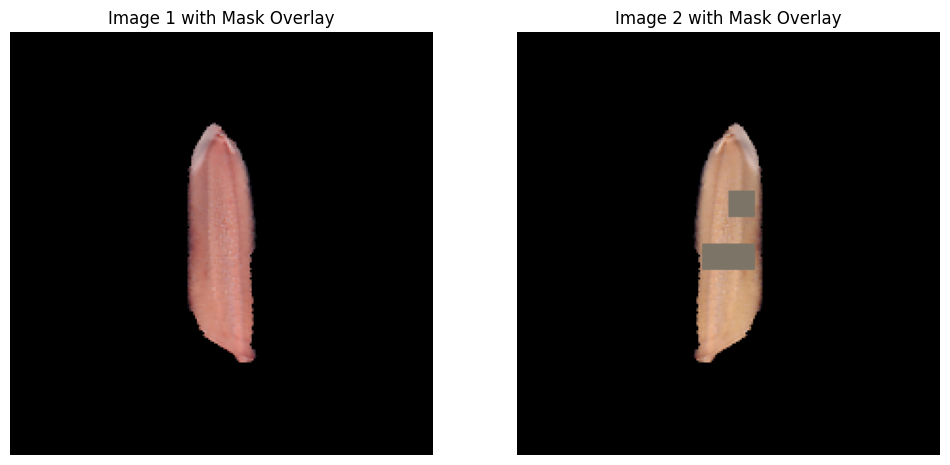

In [2833]:
patch_size = 14
image_size = 224
patches_per_dim = image_size // patch_size  # This will be 16 for both height and width

# Function to create a masked image
def create_masked_image(image, mask, patch_size, patches_per_dim):
    masked_image = image.clone()
    for i in range(patches_per_dim):
        for j in range(patches_per_dim):
            if mask[i, j] == 1:  # If the patch is masked
                masked_image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 0
    return masked_image

# Create the masked images for both images with their respective masks
masked_image1 = create_masked_image(global_crops_teacher[0], data_loader["collated_masks"][0].view(16, 16), patch_size, patches_per_dim)
masked_image2 = create_masked_image(global_crops_teacher[1], data_loader["collated_masks"][1].view(16, 16), patch_size, patches_per_dim)

# Convert both masked images to numpy for visualization
masked_image1_np = denormalize(masked_image1).permute(1, 2, 0).numpy()
masked_image2_np = denormalize(masked_image2).permute(1, 2, 0).numpy()

# Plot the images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
axes[0].imshow(masked_image1_np)
axes[0].set_title("Image 1 with Mask Overlay")
axes[0].axis('off')  # Hide axes

axes[1].imshow(masked_image2_np)
axes[1].set_title("Image 2 with Mask Overlay")
axes[1].axis('off')  # Hide axes

plt.show()

In [2834]:
collated_local_masks[0].resize(7,7)

tensor([[False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False],
        [False, False, False,  True, False, False, False],
        [False, False, False, False,  True, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False]])

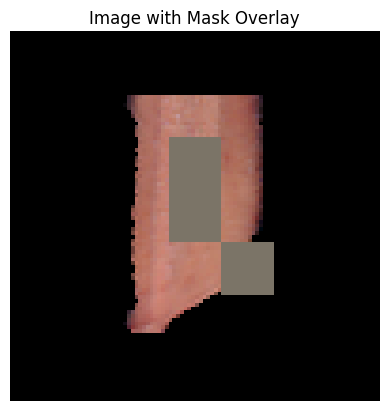

In [2835]:
image = local_crops[0]

# Image size: 224x224
# Patch size: 14x14
patch_size = 14
image_size = 98
patches_per_dim = image_size // patch_size  # This will be 16 for both height and width

# Create a masked image by copying the original image
masked_image = image.clone()

# Iterate through the patches and overlay the mask
for i in range(patches_per_dim):
    for j in range(patches_per_dim):
        if collated_local_masks[0].resize(7,7)[i, j] == 1:  # If the patch is masked
            # Set the corresponding 14x14 patch in all 3 color channels to black
            masked_image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 0

# Convert to numpy for visualization (from torch tensor)
masked_image_np = denormalize(masked_image).permute(1, 2, 0).numpy()

# Plot the image with overlay
plt.imshow(masked_image_np)
plt.title("Image with Mask Overlay")
plt.axis('off')  # Hide axes
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

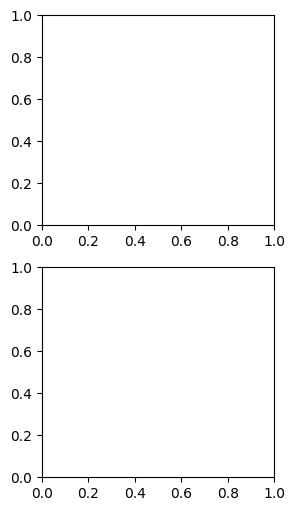

In [1185]:
def visualize_local_crops(local_crops, collated_local_masks, denormalize):
    num_crops = len(local_crops)  # Should be 10
    patch_size = 14
    image_size = 98
    patches_per_dim = image_size // patch_size  # This will be 7, not 16
    cols = 1  # Number of images per row
    rows = (num_crops + cols - 1) // cols  # Calculate needed rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for idx in range(num_crops):
        image = local_crops[idx]  # Get crop
        mask = collated_local_masks[idx].reshape(7, 7)  # Ensure the mask is correctly shaped

        # Create a masked image by copying the original
        masked_image = image.clone()

        # Iterate through the patches and overlay the mask
        for i in range(patches_per_dim):
            for j in range(patches_per_dim):
                if mask[i, j] == 1:  # If the patch is masked
                    masked_image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 0

        # Convert to numpy for visualization
        masked_image_np = denormalize(masked_image).permute(1, 2, 0).numpy()

        # Determine subplot position
        row, col = divmod(idx, cols)
        axes[row, col].imshow(masked_image_np)
        axes[row, col].set_title(f"Masked {idx+1}")
        axes[row, col].axis("off")

    # Hide any unused subplots
    for idx in range(num_crops, rows * cols):
        row, col = divmod(idx, cols)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
visualize_local_crops(local_crops, collated_local_masks, denormalize)

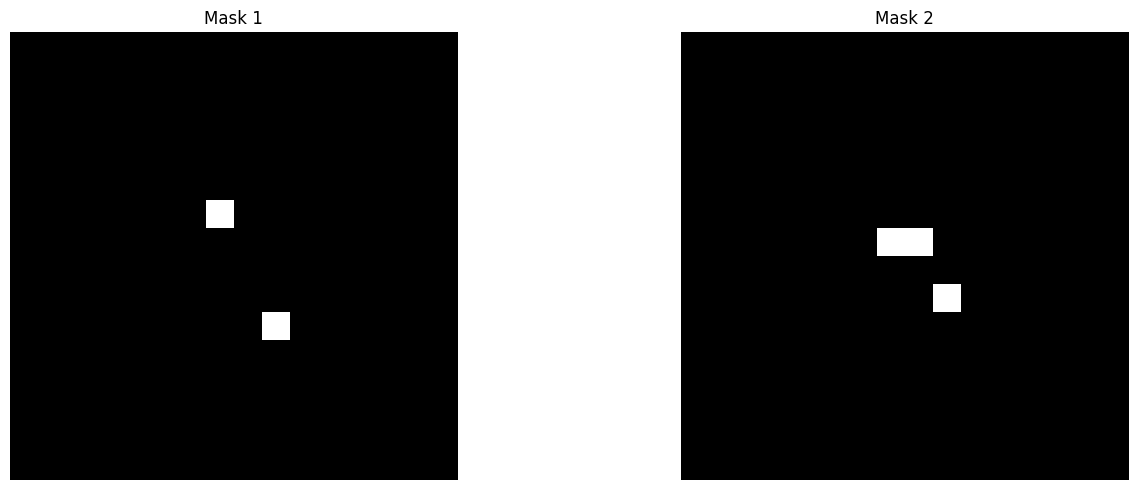

In [27]:
# Create a figure to hold the subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Display the first mask (collated_masks1) in the first subplot
axes[0].imshow(collated_masks1.cpu().numpy(), cmap="gray")
axes[0].set_title("Mask 1")
axes[0].axis("off")  # Turn off axis labels

# Display the second mask (collated_masks2) in the second subplot
axes[1].imshow(collated_masks2.cpu().numpy(), cmap="gray")
axes[1].set_title("Mask 2")
axes[1].axis("off")  # Turn off axis labels

# Show the plot
plt.tight_layout()
plt.show()

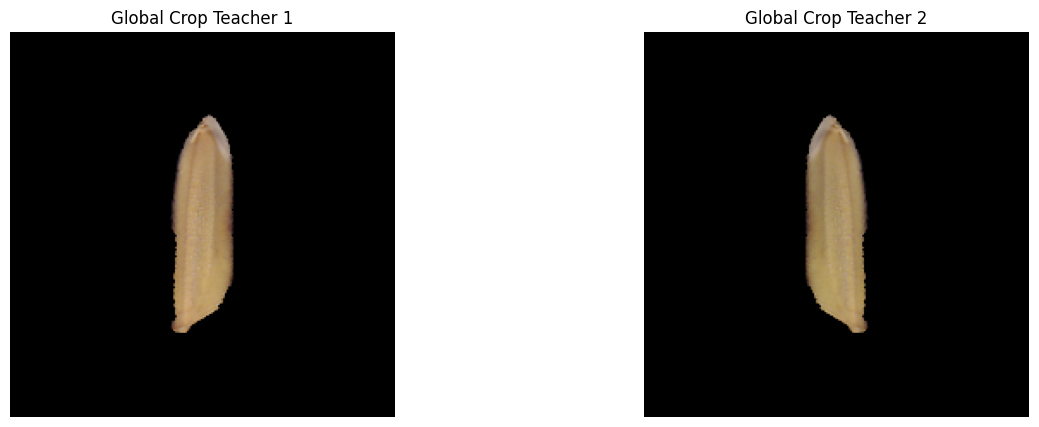

In [4486]:

# Display the crops
fig, axes = plt.subplots(1, len(global_crops_teacher), figsize=(15, 5))

for i, crop in enumerate(global_crops_teacher):
    if isinstance(crop, torch.Tensor):
        crop = denormalize(crop)  # Denormalize the tensor
        crop = F.to_pil_image(crop)  # Convert tensor to PIL image
    axes[i].imshow(crop)
    axes[i].axis("off")
    axes[i].set_title(f"Global Crop Teacher {i+1}")

plt.show()

In [4487]:
crop.size

(224, 224)

In [748]:

# # Display the crops
# fig, axes = plt.subplots(1, len(local_crops), figsize=(15, 5))

# for i, crop in enumerate(local_crops):
#     if isinstance(crop, torch.Tensor):
#         crop = denormalize(crop)  # Denormalize the tensor
#         crop = F.to_pil_image(crop)  # Convert tensor to PIL image
#     axes[i].imshow(crop)
#     axes[i].axis("off")

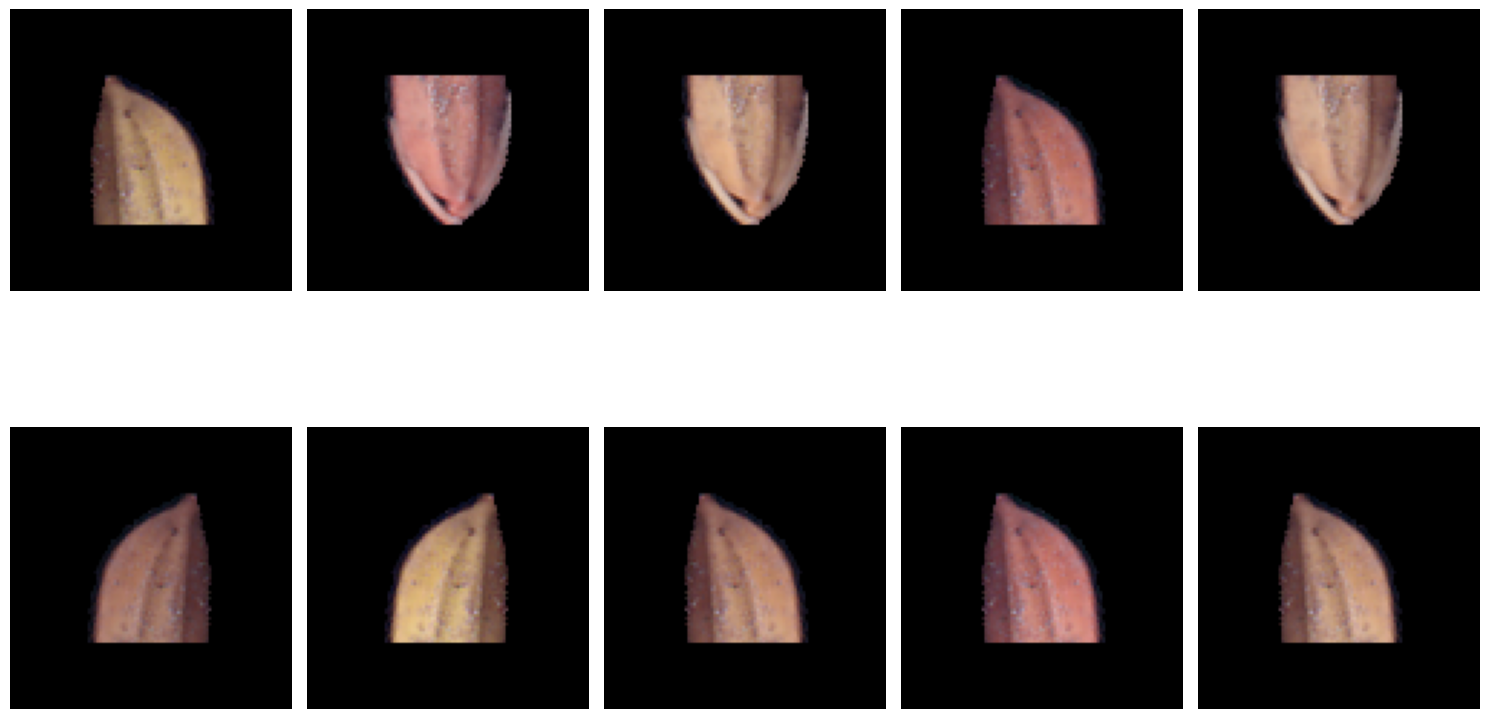

In [749]:
# Assuming local_crops is a list of images (Tensors or PIL images)
num_crops = len(local_crops)
num_cols = math.ceil(num_crops / 2)  # Number of columns (adjust to fit 2 rows)
num_rows = 2  # Fixed to two rows

# Create the subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten axes if there's only one row
axes = axes.flatten() if num_crops > 1 else [axes]

for i, crop in enumerate(local_crops):
    if isinstance(crop, torch.Tensor):
        crop = denormalize(crop)  # Denormalize the tensor
        crop = F.to_pil_image(crop)  # Convert tensor to PIL image
    axes[i].imshow(crop)
    axes[i].axis("off")

# Hide any extra unused subplots (if crops are not a perfect multiple of columns)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()